### Import libraries

In [1]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from fvcore.nn import FlopCountAnalysis, flop_count_table
from datasets.cityscapes import CityScapes
from utils import fast_hist, per_class_iou
from models.deeplabv2.deeplabv2 import get_deeplab_v2

# Ignore warnings
warnings.filterwarnings("ignore")

### Training - Single Channel

In [2]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
# Set the model to training mode
model.train()

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)

# Train the model
for epoch in range(50):
    # Initialize the hist matrix at each epoch
    hist = np.zeros((19, 19))
    for image, label in tqdm(dataloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)[0]
        # Calculate the loss
        loss = criterion(output, label)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)
        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/deeplabv2/deeplabv2.pth')

Deeplab pretraining loading...


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 0, Loss: 0.553043782711029, mIoU: 0.2021105818976533


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 1, Loss: 0.47752517461776733, mIoU: 0.28774379904808334


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 2, Loss: 0.5663291811943054, mIoU: 0.3442506217685209


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 3, Loss: 0.47179892659187317, mIoU: 0.3961622869082931


100%|██████████| 786/786 [05:05<00:00,  2.57it/s]


Epoch: 4, Loss: 0.46497854590415955, mIoU: 0.4537059407203886


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 5, Loss: 0.43520039319992065, mIoU: 0.4863580751650886


100%|██████████| 786/786 [05:07<00:00,  2.55it/s]


Epoch: 6, Loss: 0.22313667833805084, mIoU: 0.5220804393253486


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 7, Loss: 0.25954124331474304, mIoU: 0.5694881126982567


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 8, Loss: 0.18319326639175415, mIoU: 0.5947510056988287


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 9, Loss: 0.20082753896713257, mIoU: 0.6197253141962246


100%|██████████| 786/786 [05:05<00:00,  2.58it/s]


Epoch: 10, Loss: 0.15699158608913422, mIoU: 0.6192676129049591


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 11, Loss: 0.23032595217227936, mIoU: 0.6503587004943447


100%|██████████| 786/786 [05:05<00:00,  2.57it/s]


Epoch: 12, Loss: 0.125193789601326, mIoU: 0.6761246105670256


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 13, Loss: 0.15366369485855103, mIoU: 0.6961547261689511


100%|██████████| 786/786 [05:02<00:00,  2.60it/s]


Epoch: 14, Loss: 0.22140002250671387, mIoU: 0.6995693135073674


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 15, Loss: 0.14555788040161133, mIoU: 0.6851104976773941


100%|██████████| 786/786 [05:15<00:00,  2.49it/s]


Epoch: 16, Loss: 0.12367022782564163, mIoU: 0.7119231774201213


100%|██████████| 786/786 [05:15<00:00,  2.49it/s]


Epoch: 17, Loss: 0.2485109120607376, mIoU: 0.6169373142384408


100%|██████████| 786/786 [05:14<00:00,  2.50it/s]


Epoch: 18, Loss: 0.20101895928382874, mIoU: 0.6854081952234109


100%|██████████| 786/786 [05:15<00:00,  2.50it/s]


Epoch: 19, Loss: 0.1453121453523636, mIoU: 0.7324866831881586


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 20, Loss: 0.12937895953655243, mIoU: 0.7467489450549065


100%|██████████| 786/786 [05:05<00:00,  2.57it/s]


Epoch: 21, Loss: 0.13091346621513367, mIoU: 0.7527345295253952


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 22, Loss: 0.515529215335846, mIoU: 0.6907554965166707


100%|██████████| 786/786 [05:12<00:00,  2.51it/s]


Epoch: 23, Loss: 0.1978570818901062, mIoU: 0.5827733713362975


100%|██████████| 786/786 [05:13<00:00,  2.51it/s]


Epoch: 24, Loss: 0.1848665028810501, mIoU: 0.6867160170097385


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 25, Loss: 0.10619790852069855, mIoU: 0.7371777605574671


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 26, Loss: 0.23902565240859985, mIoU: 0.7225975263042912


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 27, Loss: 0.19775784015655518, mIoU: 0.6142115678674056


100%|██████████| 786/786 [05:05<00:00,  2.58it/s]


Epoch: 28, Loss: 0.12195564061403275, mIoU: 0.7215678056014624


100%|██████████| 786/786 [05:03<00:00,  2.59it/s]


Epoch: 29, Loss: 0.11178136616945267, mIoU: 0.7530396521229707


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 30, Loss: 0.10478554666042328, mIoU: 0.7668996637720064


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 31, Loss: 0.15971994400024414, mIoU: 0.7750454894262168


100%|██████████| 786/786 [05:12<00:00,  2.52it/s]


Epoch: 32, Loss: 0.10971340537071228, mIoU: 0.7795342945917414


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 33, Loss: 0.10409864783287048, mIoU: 0.7825698393033483


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 34, Loss: 0.0891982913017273, mIoU: 0.7839745371405498


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 35, Loss: 0.08193924278020859, mIoU: 0.785042596072116


100%|██████████| 786/786 [05:13<00:00,  2.51it/s]


Epoch: 36, Loss: 0.078034408390522, mIoU: 0.7869150704042301


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 37, Loss: 0.572129487991333, mIoU: 0.6729410292756244


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 38, Loss: 0.3263585865497589, mIoU: 0.47690025036163963


100%|██████████| 786/786 [05:14<00:00,  2.50it/s]


Epoch: 39, Loss: 0.20485682785511017, mIoU: 0.625960480180729


100%|██████████| 786/786 [05:15<00:00,  2.49it/s]


Epoch: 40, Loss: 0.1139967292547226, mIoU: 0.685608542289343


100%|██████████| 786/786 [05:14<00:00,  2.50it/s]


Epoch: 41, Loss: 0.10928419232368469, mIoU: 0.7453647363685768


100%|██████████| 786/786 [05:15<00:00,  2.49it/s]


Epoch: 42, Loss: 0.14335493743419647, mIoU: 0.7694573894847943


100%|██████████| 786/786 [05:16<00:00,  2.48it/s]


Epoch: 43, Loss: 0.12516455352306366, mIoU: 0.7809158644462268


100%|██████████| 786/786 [05:16<00:00,  2.48it/s]


Epoch: 44, Loss: 0.155853733420372, mIoU: 0.7846785250047211


100%|██████████| 786/786 [05:12<00:00,  2.51it/s]


Epoch: 45, Loss: 0.07593628019094467, mIoU: 0.7898872599589791


100%|██████████| 786/786 [05:16<00:00,  2.49it/s]


Epoch: 46, Loss: 0.10612814128398895, mIoU: 0.791837760455811


100%|██████████| 786/786 [05:13<00:00,  2.51it/s]


Epoch: 47, Loss: 0.08883807808160782, mIoU: 0.7931508719526557


100%|██████████| 786/786 [05:12<00:00,  2.52it/s]


Epoch: 48, Loss: 0.08515504002571106, mIoU: 0.7947353057565468


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 49, Loss: 0.3581680357456207, mIoU: 0.6349726396827168


### Validation

In [3]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    miou = np.mean(per_class_iou(hist))
    
# Print the mIoU
print(f'mIoU: {miou}')

Deeplab pretraining loading...


500it [00:32, 15.32it/s]

mIoU: 0.3703682308057555


### Example

Deeplab pretraining loading...


0it [00:00, ?it/s]


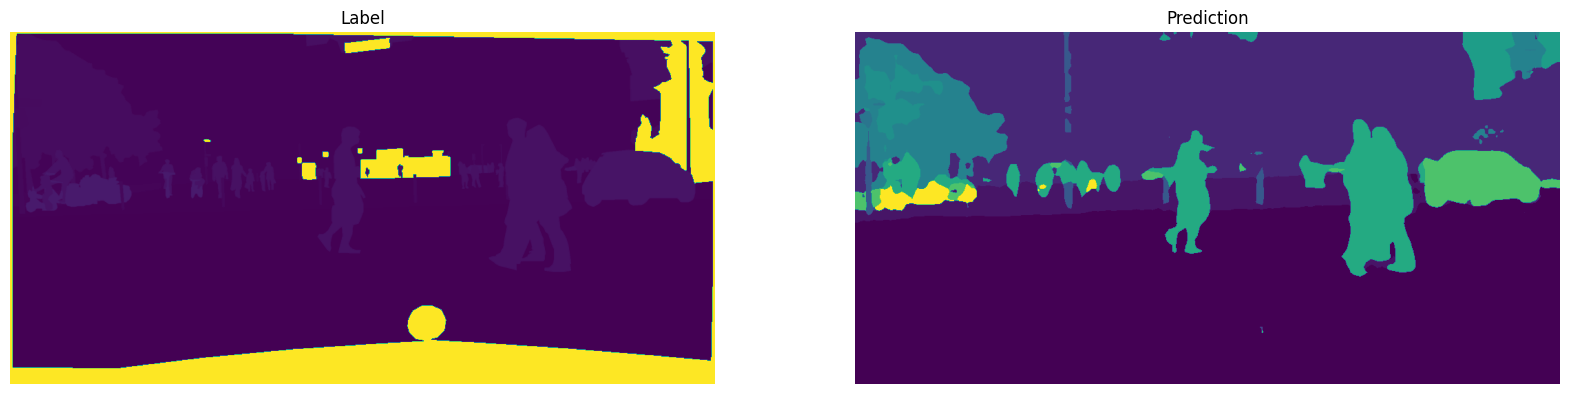

In [6]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Break after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### FLOPs and Parameters

In [7]:
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the number of flops
flops = FlopCountAnalysis(model, image.unsqueeze(0))
# Get the number of flops
flops = flop_count_table(flops)
# Get the number of parameters
params = sum(p.numel() for p in model.parameters())

# Print the number of parameters and flops
print(f'Number of parameters: {params}\n')
print(flops)

Deeplab pretraining loading...
Number of parameters: 43901068

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 0.375T     |
|  conv1                         |  9.408K                |  1.233G    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  16.777M   |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  7.155G    |
|   layer1.0                     |   75.008K              |   2.487G   |
|    layer1.0.conv1              |    4.096K              |    0.136G  |
|    layer1.0.bn1                |    0.128K              |    4.244M  |
|    layer1.0.conv2              |    36.864K             |  

### Latency and FPS

In [14]:
# Set the device
device = torch.device('cuda')   

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.to(device).eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the latency and FPS
iterations = 1000
latency = []
fps = []

# Compute the latency and FPS
for _ in range(iterations):
    start = time()
    model(image.unsqueeze(0).to(device))
    end = time()
    latency.append(end - start)
    fps.append(1 / (end - start))

# Compute the average latency and FPS
mean_latency = np.mean(latency)
mean_fps = np.mean(fps)
std_latency = np.std(latency)
std_fps = np.std(fps)

# Print the latency and FPS
print(f'Latency: {mean_latency:.3f} +/- {std_latency:.3f}')
print(f'FPS: {mean_fps:.3f} +/- {std_fps:.3f}')

Deeplab pretraining loading...
Latency: 0.059 +/- 0.002
FPS: 17.188 +/- 4.221
